In [62]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio import plot, mask
from rasterstats import zonal_stats
import xarray
import numpy as np
from dateutil import parser
import os

# Import polygons

In [16]:
# import landslide polygons
shapefile_shx = "../0-brute-raw-data/Landslides.shx"
nz_landslide_polygons = gpd.read_file(shapefile_shx)
nz_landslide_polygons

,OBJECTID,LD,Shape_Leng,Shape_Area,area,xLoc,yLoc,geometry
0,1,1,6294.572688,971012.709717,971012.709717,None,None,"POLYGON ((224168.801 5319214.443, 224176.674 5..."
1,2,0,534.474179,6510.391251,6510.391251,None,None,"POLYGON ((224135.776 5318458.596, 224137.014 5..."
2,3,0,1600.066686,46399.058635,46399.058635,None,None,"POLYGON ((223868.599 5318137.775, 223855.370 5..."
3,4,0,1645.958267,34457.252781,34457.252781,None,None,"POLYGON ((224014.114 5317351.976, 224004.037 5..."
4,5,0,316.753483,4571.300600,4571.300600,None,None,"POLYGON ((224074.165 5317697.594, 224088.204 5..."
...,...,...,...,...,...,...,...,...
14228,14230,1,719.732270,24666.229609,24666.229609,None,None,"POLYGON ((234482.468 5349619.469, 234485.797 5..."
14229,14231,0,787.175176,24079.652938,24079.652938,None,None,"POLYGON ((194301.472 5289968.004, 194311.884 5..."
14230,14232,1,1009.043796,43493.688376,43493.688376,None,None,"POLYGON ((194361.309 5290054.116, 194360.043 5..."
14231,14233,0,1046.510759,25285.918579,25285.918579,None,None,"POLYGON ((230603.338 5345977.410, 230596.440 5..."


In [17]:
%matplotlib inline

<Axes: >

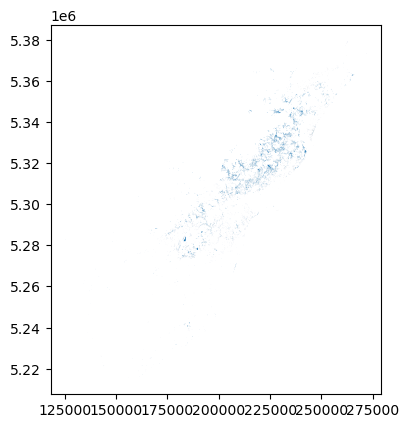

In [18]:
nz_landslide_polygons.plot()

# Match crs

In [55]:
img_folder = "../1-raw-data/ndvi/"

test_fn = "LC08_L2SP_073089_20161215_20200905_02_T1_ndvi"

test_src = rio.open(img_folder + test_fn+".TIF")
ndvi_crs = test_src.crs
ndvi_crs

CRS.from_epsg(32659)

In [20]:
nz_landslide_polygons.crs

<Projected CRS: EPSG:32760>
Name: WGS 84 / UTM zone 60S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 174°E and 180°E, southern hemisphere between 80°S and equator, onshore and offshore. New Zealand.
- bounds: (174.0, -80.0, 180.0, 0.0)
Coordinate Operation:
- name: UTM zone 60S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [51]:
nz_landslide_reprojected = nz_landslide_polygons.to_crs(ndvi_crs)
nz_landslide_reprojected.crs

<Projected CRS: EPSG:32659>
Name: WGS 84 / UTM zone 59N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 59N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
r= test_src.read(1, masked = True)

<Axes: >

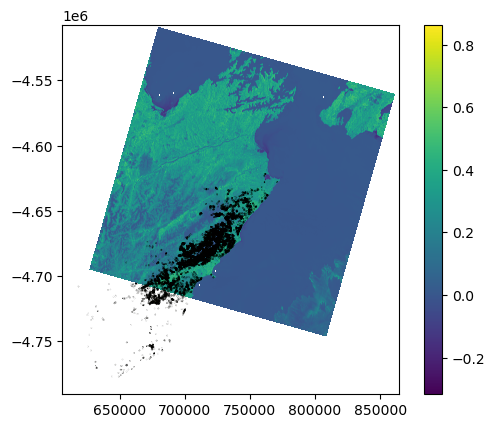

In [23]:
ndvi_extent = rio.plot.plotting_extent(test_src)

f, ax = plt.subplots()
a = ax.imshow(r, extent=ndvi_extent)
f.colorbar(a)
nz_landslide_reprojected.plot(ax=ax, facecolor='y', edgecolor='k')

In [24]:
test_src.nodata

999.9000244140625

# Find NDVI statistics for each polygon

In [25]:
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
nz_ma, nz_ma_transform = rio.mask.mask(test_src, nz_landslide_reprojected.geometry, **rio_mask_kwargs)
nz_ma_extent = rio.plot.plotting_extent(nz_ma, nz_ma_transform)

In [43]:
mean_above_zero = lambda l: l[l>0].mean()
count_above_zero = lambda l: np.count_nonzero(l[l>0])


'<function <lambda> at 0x000002BA0D9CB9A0>'

In [46]:
stats = ['count', 'mean']
zonalstats = zonal_stats(nz_landslide_reprojected, raster=r, affine=test_src.transform,nodata=test_src.nodata,
            stats=stats)
zonalstats


[{'mean': 0.028924401364805088, 'count': 1076},
 {'mean': 0.03191793816430228, 'count': 7},
 {'mean': 0.0334006431056004, 'count': 51},
 {'mean': 0.1073705742998821, 'count': 41},
 {'mean': 0.1257871389389038, 'count': 4},
 {'mean': 0.09082699815432231, 'count': 6},
 {'mean': 0.14493286609649658, 'count': 8},
 {'mean': 0.15114925305048624, 'count': 12},
 {'mean': 0.11552965256475634, 'count': 31},
 {'mean': 0.1398301883177324, 'count': 11},
 {'mean': 0.094236026207606, 'count': 12},
 {'mean': 0.13039355278015136, 'count': 5},
 {'mean': 0.11062486171722412, 'count': 15},
 {'mean': 0.13769592344760895, 'count': 8},
 {'mean': 0.2845979928970337, 'count': 3},
 {'mean': 0.17890357971191406, 'count': 6},
 {'mean': 0.1164931297302246, 'count': 5},
 {'mean': 0.23525230089823404, 'count': 9},
 {'mean': 0.23572885990142822, 'count': 3},
 {'mean': 0.24349982397896902, 'count': 14},
 {'mean': 0.13428982372941642, 'count': 29},
 {'mean': 0.13316144545873007, 'count': 6},
 {'mean': 0.112642201510342

In [52]:
nz_landslide_reprojected.head()

,OBJECTID,LD,Shape_Leng,Shape_Area,area,xLoc,yLoc,geometry
0,1,1,6294.572688,971012.709717,971012.709717,None,None,"POLYGON ((719299.877 -4678794.256, 719307.478 ..."
1,2,0,534.474179,6510.391251,6510.391251,None,None,"POLYGON ((719213.776 -4679545.646, 719214.183 ..."
2,3,0,1600.066686,46399.058635,46399.058635,None,None,"POLYGON ((718924.785 -4679846.765, 718916.619 ..."
3,4,0,1645.958267,34457.252781,34457.252781,None,None,"POLYGON ((719014.603 -4680640.581, 719006.256 ..."
4,5,0,316.753483,4571.300600,4571.300600,None,None,"POLYGON ((719098.802 -4680300.165, 719111.566 ..."


In [53]:

zonal_df = pd.DataFrame(zonalstats, columns = ['count', 'mean'])
nz_landslide_reprojected = nz_landslide_reprojected.join(zonal_df)

,OBJECTID,LD,Shape_Leng,Shape_Area,area,xLoc,yLoc,geometry,count,mean
0,1,1,6294.572688,971012.709717,971012.709717,None,None,"POLYGON ((719299.877 -4678794.256, 719307.478 ...",1076,0.028924
1,2,0,534.474179,6510.391251,6510.391251,None,None,"POLYGON ((719213.776 -4679545.646, 719214.183 ...",7,0.031918
2,3,0,1600.066686,46399.058635,46399.058635,None,None,"POLYGON ((718924.785 -4679846.765, 718916.619 ...",51,0.033401
3,4,0,1645.958267,34457.252781,34457.252781,None,None,"POLYGON ((719014.603 -4680640.581, 719006.256 ...",41,0.107371
4,5,0,316.753483,4571.300600,4571.300600,None,None,"POLYGON ((719098.802 -4680300.165, 719111.566 ...",4,0.125787


In [60]:
zonal_df.to_csv("../2-processed data/ndvi/" + test_fn + ".csv")

In [ ]:
%matplotlib widget

In [ ]:
nz_landslide_reprojected['mean'].min()

-0.04050507148106893

<Axes: >

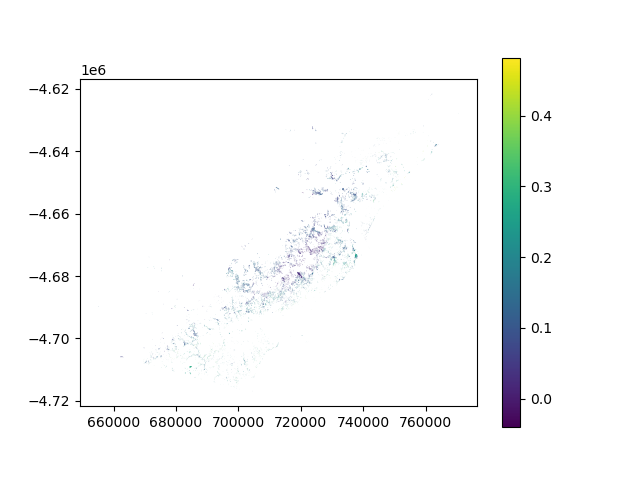

In [ ]:
nz_landslide_reprojected.plot('mean', legend=True)

# Calculate stats for each time

In [75]:
images = []

for input in ['img_list.txt', 'autoselected_images.txt']:
    with open(img_folder + input) as f:
        for l in f:
            id = l.split(',')[1]
            if os.path.exists(img_folder + id + "_ndvi.TIF"):
                images.append(id)
            elif os.path.exists(img_folder + id[:-1] + "_ndvi.TIF"):
                images.append(id[:-1])

images

['LC08_L2SP_073089_20161215_20200905_02_T1',
 'LC08_L2SP_073089_20160419_20200907_02_T1',
 'LC08_L2SP_073089_20161012_20200905_02_T1',
 'LC08_L2SP_073089_20161215_20200905_02_T1',
 'LC08_L2SP_073089_20171202_20200902_02_T1',
 'LC08_L2SP_073089_20181018_20200830_02_T1',
 'LC08_L2SP_073089_20201210_20210313_02_T1',
 'LC09_L2SP_073089_20221122_20230321_02_T1',
 'LC08_L2SP_073089_20231219_20240103_02_T1',
 'LE07_L2SP_074089_20231210_20240105_02_T1',
 'LC09_L2SP_073089_20231125_20231128_02_T1',
 'LC08_L2SP_073089_20221114_20221122_02_T1',
 'LC09_L2SP_073089_20221106_20221110_02_T1',
 'LE07_L2SP_073089_20221104_20221130_02_T1',
 'LE07_L2SP_073089_20201202_20201229_02_T1',
 'LC08_L2SP_073089_20201023_20201105_02_T1',
 'LC08_L2SP_073089_20191208_20200824_02_T1',
 'LC08_L2SP_073089_20191005_20200825_02_T1',
 'LC08_L2SP_073089_20181018_20200830_02_T1',
 'LC08_L2SP_073089_20171202_20200902_02_T1',
 'LC08_L2SP_073089_20161215_20200905_02_T1',
 'LC08_L2SP_073089_20161012_20200905_02_T1',
 'LC08_L2S

In [78]:
def clip_to_polygons(img, gpd):
    src = rio.open(img_folder + img+"_ndvi.TIF")
    r = src.read(1, masked=True)
    zonalstats = zonal_stats(gpd, raster=r, affine=src.transform,nodata=src.nodata,
            stats=['count', 'mean'])
    zonal_df = pd.DataFrame(zonalstats, columns = ['count', 'mean'])
    zonal_df.to_csv("../2-processed data/ndvi/" + img + ".csv")

In [79]:
clip_to_polygons(images[0], nz_landslide_reprojected)